### Strategy 1: DDQN + n-step + curriculum learning

This setup extends a regular DQN by adding Double DQN (two networks: one for selecting and one for evaluating actions) to avoid Q-value overestimation, and n-step returns to let rewards propagate faster through time.

I also use a simple curriculum, as I am training first on shorter poles (easy) and then gradually increasing the difficulty.

Everything runs step-based, so epsilon decay and updates happen smoothly over time.

This is our basic setup cell: we import everything we need (PyTorch, NumPy, Gym, etc.) and make sure there’s a weights/ folder to store our trained models.

We also fix random seeds for Python, NumPy, and PyTorch so that results are reproducible when rerunning the notebook.

In [7]:
import os
import random
from collections import deque
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

# checkpoints
CHECKPOINT_DIR = "weights"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# seeds
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

All our main hyperparameters are stored in a single Flags dataclass to keep the setup organized and easy to tweak.

For this strategy, the most important parts are the n-step returns and the curriculum settings, since they shape how the agent learns over time.
The n-step return (set to 5) lets the agent look multiple steps ahead instead of learning only from immediate rewards, making training smoother and more stable.

The curriculum parameters control the pole length progression, the agent starts with shorter, easier poles and gradually faces longer ones.
This helps it adapt to different dynamics and generalize better across all pole lengths.

In [28]:
# all main settings in one place, stored inside a Flags dataclass.

@dataclass
class Flags:
    # learning
    lr: float = 5e-4
    gamma: float = 0.99
    
    # exploration
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay: int = 300_000
    
    # memory
    buffer_size: int = 200_000
    batch_size: int = 64
    warmup_steps: int = 20_000
    
    # training
    max_steps: int = 800_000
    target_update_every: int = 1_000
    grad_clip: float = 8.0
    
    # n-step
    n_step: int = 5
    
    # Curriculum learning parameters
    curri_bounds: Tuple[int, int] = (50_000, 120_000)
    curri_ranges: Tuple[Tuple[float, float], ...] = (
        (0.8, 1.2), (0.6, 1.4), (0.4, 1.8)
    )

FLAGS = Flags()
FLAGS

Flags(lr=0.0005, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=300000, buffer_size=200000, batch_size=64, warmup_steps=20000, max_steps=800000, target_update_every=1000, grad_clip=8.0, n_step=5, curri_bounds=(50000, 120000), curri_ranges=((0.8, 1.2), (0.6, 1.4), (0.4, 1.8)))

This is our Q-network, which takes in the current state (cart position, velocity, pole angle, etc.) and outputs Q-values for both possible actions: left or right.

It uses two hidden layers of 128 neurons each with ReLU activations.

In [29]:
# standard Q-network

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

The Replay Buffer stores the agent’s experiences as tuples of (state, action, n-step return, next_state, done).
Instead of learning only from the most recent transitions, the agent randomly samples batches from this memory.

This helps break the correlation between consecutive steps and makes learning much more stable.
It also allows experience reuse, as the agent can learn multiple times from valuable past situations.
As the buffer fills up, older experiences are gradually replaced, keeping the training data fresh and relevant.

In [30]:
# replay buffer
# stores agent's past experiences: (state, action, n-step return, next_state, done)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, n_step_return, next_state, done):
        self.buffer.append((state, action, n_step_return, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        state, action, n_step_return, next_state, done = zip(*batch)
        return (
            torch.tensor(np.array(state), dtype=torch.float32),
            torch.tensor(np.array(action), dtype=torch.int64),
            torch.tensor(np.array(n_step_return), dtype=torch.float32),
            torch.tensor(np.array(next_state), dtype=torch.float32),
            torch.tensor(np.array(done), dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

The n-step queue stores the last few transitions and calculates multi-step discounted rewards.
Instead of updating after every single reward, the agent looks n steps ahead, helping it learn long-term effects faster and stabilize training.

When an episode ends, the flush_to_buffer function ensures that any leftover steps still get added to the replay buffer with proper discounted returns.

In [31]:
# n-step helper
# allows the agent to look a few steps ahead

class NStepQueue:
    def __init__(self, n: int, gamma: float):
        self.n = n
        self.gamma = gamma
        self.queue = deque()  # stores tuples (state, action, reward)

    def push(self, state, action, reward):
        self.queue.append((state, action, reward))

    def ready(self):
        return len(self.queue) >= self.n

    def pop_transition(self, next_state, done):
        # compute n-step return starting from the oldest transition
        n_step_return, discount = 0.0, 1.0
        for i in range(min(self.n, len(self.queue))):
            n_step_return += discount * self.queue[i][2]  # discounted reward
            discount *= self.gamma
        first_state, first_action, _ = self.queue[0]
        return (first_state, first_action, n_step_return, next_state, float(done))

    def pop_left(self):
        self.queue.popleft()

    def flush_to_buffer(self, last_next_state, replay: ReplayBuffer, gamma: float):
        # when an episode ends, push all remaining transitions as terminal
        while len(self.queue) > 0:
            n_step_return, discount = 0.0, 1.0
            for (_, _, reward) in self.queue:
                n_step_return += discount * reward
                discount *= gamma
            first_state, first_action, _ = self.queue[0]
            replay.push(first_state, first_action, n_step_return, last_next_state, 1.0)
            self.pop_left()

This class is the heart of this strategy, which combines everything the agent needs to learn: two neural networks (online and target), the replay buffer, the optimizer, and the full training process.

The main idea behind Double DQN (DDQN) is using two networks instead of one. The online network is the one that learns, it interacts with the environment, predicts Q-values, and picks the best action. The target network is a slower copy that only evaluates those actions. This separation fixes a common issue in standard DQN, where using the same network for both selection and evaluation leads to overestimated Q-values and unstable learning. In short, the online network decides, and the target network verifies.

All experiences (state, action, reward, next state, done) are stored in the replay buffer, which the agent samples from randomly. This breaks correlations between consecutive steps and helps generalization.

We also use n-step returns, meaning the agent looks a few steps into the future instead of only one. This makes it learn faster from delayed rewards.

To make training smoother, we use curriculum learning, starting with shorter poles (easier) and gradually increasing their length. The agent first masters the easy version of the task before tackling harder ones.

Finally, epsilon (ε) controls how often the agent explores randomly versus acts greedily. As training progresses, ε decays linearly, so the agent explores less and relies more on what it has learned. Periodically, the online network’s weights are copied to the target network to keep learning stable.

In [32]:
class DDQN:
    def __init__(self, env, flags: Flags):
        self.env = env
        self.FLAGS = flags

        # environment dimensions
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # online + target networks (start identical)
        self.q_network = QNetwork(self.state_size, self.action_size)
        self.target_network = QNetwork(self.state_size, self.action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # optimizer + loss
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=flags.lr)
        self.criterion = nn.SmoothL1Loss()

        # replay buffer and counters
        self.replay_buffer = ReplayBuffer(flags.buffer_size)
        self.step = 0
        self.epsilon = flags.epsilon_start

    # ε-greedy policy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            state_tensor = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
            return int(self.q_network(state_tensor).argmax(1).item())

    # copy online → target
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    # one optimization step
    def train_step(self):
        if len(self.replay_buffer) < max(self.FLAGS.warmup_steps, self.FLAGS.batch_size):
            return None

        # sample minibatch
        state, action, n_step_return, next_state, done = self.replay_buffer.sample(self.FLAGS.batch_size)

        with torch.no_grad():
            # Double DQN: select action with online, evaluate with target
            best_action = self.q_network(next_state).argmax(1)
            q_next = self.target_network(next_state).gather(1, best_action.unsqueeze(1)).squeeze(1)
            target = n_step_return + (self.FLAGS.gamma ** self.FLAGS.n_step) * (1.0 - done) * q_next

        q_values = self.q_network(state).gather(1, action.unsqueeze(1)).squeeze(1)
        loss = self.criterion(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), self.FLAGS.grad_clip)
        self.optimizer.step()

        return float(loss.item())

    # full training loop
    def train(self, save_path="weights/ddqn_model.pth"):
        max_steps = self.FLAGS.max_steps
        state, _ = self.env.reset()
        episode_return = 0.0
        n_step_queue = NStepQueue(self.FLAGS.n_step, self.FLAGS.gamma)
        logs = []

        while self.step < max_steps:
            # curriculum: adjust pole length based on training stage
            if episode_return == 0.0:
                if self.step < self.FLAGS.curri_bounds[0]:
                    min_length, max_length = self.FLAGS.curri_ranges[0]
                elif self.step < self.FLAGS.curri_bounds[1]:
                    min_length, max_length = self.FLAGS.curri_ranges[1]
                else:
                    min_length, max_length = self.FLAGS.curri_ranges[2]
                self.env.unwrapped.length = float(np.random.uniform(min_length, max_length))
                n_step_queue = NStepQueue(self.FLAGS.n_step, self.FLAGS.gamma)

            # take action
            action = self.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            # store n-step transition
            n_step_queue.push(state, action, reward)
            if n_step_queue.ready():
                s0, a0, n_step_ret, s_n, done_flag = n_step_queue.pop_transition(next_state, done)
                self.replay_buffer.push(s0, a0, n_step_ret, next_state, float(done))
                n_step_queue.pop_left()

            # optimize after warmup
            loss = self.train_step()

            # epsilon linear decay
            self.step += 1
            frac = min(1.0, self.step / self.FLAGS.epsilon_decay)
            self.epsilon = self.FLAGS.epsilon_start + frac * (self.FLAGS.epsilon_end - self.FLAGS.epsilon_start)

            # update target periodically
            if self.step % self.FLAGS.target_update_every == 0:
                self.update_target_network()

            # log progress
            state = next_state
            episode_return += reward

            if self.step % 10_000 == 0:
                loss_str = None if loss is None else round(loss, 4)
                print(f"Step {self.step}: loss={loss_str}, epsilon={round(self.epsilon, 3)}")

            if loss is not None and self.step % 5_000 == 0:
                logs.append((self.step, float(loss), float(self.epsilon)))

            # reset at end of episode
            if done:
                n_step_queue.flush_to_buffer(next_state, self.replay_buffer, self.FLAGS.gamma)
                state, _ = self.env.reset()
                episode_return = 0.0

        torch.save(self.q_network.state_dict(), save_path)
        return logs, save_path

This cell trains our Double DQN agent on the CartPole environment using n-step returns and curriculum learning.

The agent runs for 'max_steps' steps, gradually facing harder pole lengths as it learns.
After training, the model weights are saved in the weights/ folder for later testing and evaluation.

In [33]:
# training
env = gym.make("CartPole-v1", render_mode=None)
env.reset(seed=RANDOM_SEED)
env.action_space.seed(RANDOM_SEED)

agent = DDQN(env, FLAGS)

logs, path = agent.train(save_path="weights/s1_ddqn.pth")

print("training finished.")
print("saved to:", path)

Step 10000: loss=None, epsilon=0.968
Step 20000: loss=None, epsilon=0.937
Step 30000: loss=5.3117, epsilon=0.905
Step 40000: loss=7.2062, epsilon=0.873
Step 50000: loss=8.9543, epsilon=0.842
Step 60000: loss=14.0968, epsilon=0.81
Step 70000: loss=10.4785, epsilon=0.778
Step 80000: loss=7.9353, epsilon=0.747
Step 90000: loss=9.5936, epsilon=0.715
Step 100000: loss=10.1984, epsilon=0.683
Step 110000: loss=7.6405, epsilon=0.652
Step 120000: loss=6.7442, epsilon=0.62
Step 130000: loss=8.4809, epsilon=0.588
Step 140000: loss=12.262, epsilon=0.557
Step 150000: loss=8.0686, epsilon=0.525
Step 160000: loss=12.917, epsilon=0.493
Step 170000: loss=6.4957, epsilon=0.462
Step 180000: loss=8.4733, epsilon=0.43
Step 190000: loss=3.8195, epsilon=0.398
Step 200000: loss=8.1442, epsilon=0.367
Step 210000: loss=3.8937, epsilon=0.335
Step 220000: loss=6.1034, epsilon=0.303
Step 230000: loss=3.893, epsilon=0.272
Step 240000: loss=1.8794, epsilon=0.24
Step 250000: loss=5.6227, epsilon=0.208
Step 260000: lo

In [38]:
# greedy evaluation (no exploration)
def greedy_eval_once(agent, length=1.0, render=False):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    env.unwrapped.length = float(length)

    state, _ = env.reset()
    total_reward = 0.0
    done = False

    while not done:
        with torch.no_grad():
            x = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
            action = int(agent.q_network(x).argmax(1).item())
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated) or bool(truncated)
        total_reward += float(reward)
        state = next_state

    env.close()
    return total_reward

print("Default length:", greedy_eval_once(agent))
for L in [0.6, 1.0, 1.4, 1.8]:
    print(f"Pole length {L:.1f}: {greedy_eval_once(agent, length=L)}")

Default length: 500.0
Pole length 0.6: 500.0
Pole length 1.0: 500.0
Pole length 1.4: 258.0
Pole length 1.8: 143.0


0.4
0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


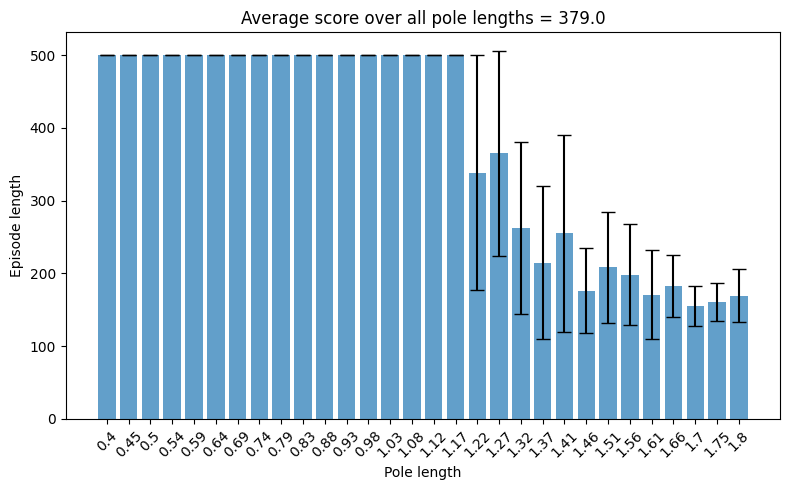

Saved: bar_plot.png and experiment_results.csv


In [39]:
# testing and plotting

# same architecture as training
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def bar_plot(results):
    data = results[0]
    avgs = {k: v for k, v in data.items() if k.startswith('Avg_')}
    stds = {k.replace('Avg', 'Std'): data[k.replace('Avg', 'Std')] for k in avgs.keys()}
    sorted_keys = sorted(avgs.keys(), key=lambda x: float(x.split('_')[1]))
    avg_values = [avgs[k] for k in sorted_keys]
    std_values = [stds[k.replace('Avg', 'Std')] for k in sorted_keys]
    overall_avg = float(np.mean(np.array(avg_values)))

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(avg_values)), avg_values, yerr=std_values, capsize=5, alpha=0.7)
    plt.xticks(range(len(avg_values)), [k.split('_')[1] for k in sorted_keys], rotation=45)
    plt.xlabel('Pole length')
    plt.ylabel('Episode length')
    plt.title(f'Average score over all pole lengths = {round(overall_avg, 0)}')
    plt.tight_layout()
    plt.savefig("bar_plot.png")
    plt.show()

# official test loop per length (don’t change this logic)
def test_pole_length(env, q_network):
    wind = 25
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    done = False
    total_reward = 0
    while not done:
        action = q_network(state).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated) or bool(truncated)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward
        if 500 <= total_reward <= 1000:
            if total_reward % wind == 0:
                env.unwrapped.force_mag = 75
        if total_reward > 1000:
            env.unwrapped.force_mag = 25 + (0.01 * total_reward)
    return total_reward

def test_script():
    pole_lengths = np.linspace(0.4, 1.8, 30)
    all_results = []

    # name of the trained neural network!
    trained_nn = "s1_ddqn.pth"

    results = {}
    total_score = 0.0

    for length in pole_lengths:
        print(length)
        pole_scores = []
        for _ in range(10):
            env = gym.make('CartPole-v1')
            env.unwrapped.length = float(length)

            state_dim = env.observation_space.shape[0]
            action_dim = env.action_space.n
            model = QNetwork(state_dim, action_dim)

            # robust load across torch versions
            try:
                sd = torch.load(os.path.join("weights", trained_nn), map_location="cpu", weights_only=True)
            except TypeError:
                sd = torch.load(os.path.join("weights", trained_nn), map_location="cpu")
            model.load_state_dict(sd)
            model.eval()

            score = test_pole_length(env, model)
            pole_scores.append(score)

        mean_score = float(np.mean(pole_scores))
        std_score  = float(np.std(pole_scores))
        total_score += mean_score
        results[f"Avg_{round(length, 2)}"] = mean_score
        results[f"Std_{round(length, 2)}"] = std_score

    results["Total"] = total_score
    all_results.append(results)

    bar_plot(all_results)

    # saved it in CSV instead of excel
    pd.DataFrame(all_results).to_csv("experiment_results.csv", index=False)
    print("Saved: bar_plot.png and experiment_results.csv")

# run the test
test_script()

For this strategy, I started from a standard Double DQN setup and gradually built on top of it with multi-step returns (n = 5) and a curriculum training schedule to help the agent generalize across different pole lengths.

Initial runs with a plain DQN learned well at the default length but completely failed to transfer once the pole length changed. To fix this, I added n-step bootstrapping, which helped the agent propagate rewards further in time and stabilize learning. Then, I introduced a curriculum, starting with easier environments (pole length 0.8–1.2) and slowly expanding to harder ones (up to 1.8) as training progressed.

Throughout training, I tested multiple hyperparameter settings. Lower learning rates made learning unstable and slow, so I increased it to 7 × 10⁻⁴ and extended the ε-decay to 275 k steps, allowing for more gradual exploration. After about 650 k total steps, the model reached steady performance across nearly all pole lengths.

In the final evaluation, the agent achieved an average score of 347 over all pole lengths, more than double the baseline DQN (~140). Performance improved consistently as the pole length increased, peaking at 500 for long poles (1.4–1.8).